In [1]:
!pip install stable-baselines3[extra]
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git
!pip install websockets>=15.0.0 --quiet
!pip install transformers --quiet
!pip install newsapi-python --quiet
!pip install alpaca-py --quiet
!pip install gymnasium --quiet
!pip install polygon-api-client --quiet

zsh:1: no matches found: stable-baselines3[extra]
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /private/var/folders/sc/40gcq14x2cng8czg1s_vpkbr0000gn/T/pip-req-build-f7_5oh6b
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /private/var/folders/sc/40gcq14x2cng8czg1s_vpkbr0000gn/T/pip-req-build-f7_5oh6b
  Resolved https://github.com/AI4Finance-Foundation/FinRL.git to commit f4283de63ca73c915321c5555fa3751698a61eec
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /private/var/folders/sc/40gcq14x2cng8czg1s_vpkbr0000gn/T/pip-install-g1muyd2a/elegantrl_6eca9ac8bda94780ae1be9128732b1ca
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/ElegantRL.git /private/var/folders/sc/40gcq14x2cng8czg1s_vpkbr0000gn/T/pip-install-g1mu

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import pkg_resources
import os
import pickle
import math
import time
import subprocess
from datetime import timedelta, date, datetime
from transformers import BertTokenizer, BertForSequenceClassification

# Alpaca imports
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest
from alpaca.trading.enums import OrderSide, TimeInForce

# Polygon import
from polygon import RESTClient

import torch as th
import torch.nn as nn
import stable_baselines3
import finrl
import gymnasium as gym
from gymnasium import spaces

from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import (
    EvalCallback,
    StopTrainingOnNoModelImprovement,
)
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.config import INDICATORS
import yfinance as yf

%matplotlib inline
plt.close('all')

print(f"SB3 Version:    {stable_baselines3.__version__}")
print(f"FinRL Version:  {pkg_resources.get_distribution('finrl').version}")

if th.backends.mps.is_available():
    DEVICE = th.device('mps')
    print("MPS (Apple Metal GPU) available — using GPU ✓")
elif th.cuda.is_available():
    DEVICE = th.device('cuda')
    print(f"CUDA GPU available — using {th.cuda.get_device_name(0)} ✓")
else:
    DEVICE = th.device('cpu')
    print("No GPU found — falling back to CPU")

print(f"Active device: {DEVICE}")

/var/folders/sc/40gcq14x2cng8czg1s_vpkbr0000gn/T/ipykernel_71009/3011431283.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SB3 Version:    2.8.0a2
FinRL Version:  0.3.8
MPS (Apple Metal GPU) available — using GPU ✓
Active device: mps


In [ ]:
# ============================================================
# CELL 2a — Alpaca + Polygon Configuration
# ============================================================
ALPACA_API_KEY    = os.environ.get('ALPACA_API_KEY', 'YOUR_ALPACA_API_KEY')
ALPACA_SECRET_KEY = os.environ.get('ALPACA_SECRET_KEY', 'YOUR_ALPACA_SECRET_KEY')
POLYGON_API_KEY   = os.environ.get('POLYGON_API_KEY', 'YOUR_POLYGON_API_KEY')
PAPER_TRADING     = True

data_client    = StockHistoricalDataClient(ALPACA_API_KEY, ALPACA_SECRET_KEY)
trading_client = TradingClient(ALPACA_API_KEY, ALPACA_SECRET_KEY,
                               paper=PAPER_TRADING)
polygon_client = RESTClient(api_key=POLYGON_API_KEY)

account = trading_client.get_account()
print(f"Alpaca connected ✅")
print(f"  Status:        {account.status}")
print(f"  Buying power:  ${float(account.buying_power):,.2f}")
print(f"  Cash:          ${float(account.cash):,.2f}")
print(f"  Paper trading: {PAPER_TRADING}")
print(f"Polygon client initialised ✅")

Alpaca connected ✅
  Status:        AccountStatus.ACTIVE
  Buying power:  $200,000.00
  Cash:          $100,000.00
  Paper trading: True
Polygon client initialised ✅


In [4]:
# ============================================================
# CELL 2b_alpaca — Alpaca Data Fetcher
# ============================================================
def fetch_alpaca_data(tickers: list[str],
                      start_date: str,
                      end_date: str) -> pd.DataFrame:
    print(f"Fetching Alpaca data: {start_date} → {end_date} "
          f"for {len(tickers)} tickers...")

    request_params = StockBarsRequest(
        symbol_or_symbols=tickers,
        timeframe=TimeFrame.Day,
        start=start_date,
        end=end_date,
        adjustment='all'
    )

    bars = data_client.get_stock_bars(request_params)
    df   = bars.df.reset_index()

    df = df.rename(columns={
        'symbol':    'tic',
        'timestamp': 'date',
    })

    df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
    df = df.sort_values(['date', 'tic']).reset_index(drop=True)
    df['day'] = df.groupby('tic').cumcount()
    df = df[['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day']]

    print(f"Fetched — shape: {df.shape}")
    print(f"Date range: {df['date'].min()} → {df['date'].max()}")
    return df


def fetch_alpaca_latest_prices(tickers: list[str]) -> pd.Series:
    request_params = StockBarsRequest(
        symbol_or_symbols=tickers,
        timeframe=TimeFrame.Day,
        start=(date.today() - timedelta(days=5)).strftime('%Y-%m-%d'),
        end=date.today().strftime('%Y-%m-%d'),
        adjustment='all'
    )
    bars = data_client.get_stock_bars(request_params)
    df   = bars.df.reset_index()
    df   = df.rename(columns={'symbol': 'tic', 'timestamp': 'date'})
    df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
    return df.sort_values('date').groupby('tic').last()['close']

In [5]:
# ============================================================
# CELL 2b — FinBERT + Polygon Sentiment Utilities
# ============================================================
SENTIMENT_DEVICE = 'cpu'

print("Loading FinBERT...")
tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')
finbert   = BertForSequenceClassification.from_pretrained('ProsusAI/finbert')
finbert   = finbert.to(SENTIMENT_DEVICE)
finbert.eval()
print("FinBERT loaded ✓")


def score_headlines(headlines: list) -> float:
    """
    Run headlines through FinBERT.
    Returns float in [-1, +1]: positive = bullish, negative = bearish.
    """
    if not headlines:
        return 0.0
    scores = []
    for text in headlines:
        inputs = tokenizer(
            text, return_tensors='pt',
            truncation=True, max_length=128, padding=True
        ).to(SENTIMENT_DEVICE)
        with th.no_grad():
            logits = finbert(**inputs).logits
            probs  = th.softmax(logits, dim=1).squeeze()
        scores.append(probs[0].item() - probs[1].item())
    return float(np.mean(scores))


def fetch_sentiment_polygon(ticker: str,
                             start_date: str,
                             end_date: str) -> pd.Series:
    """
    Fetch news headlines for a ticker from Polygon.io and score
    each day with FinBERT.

    Key advantages over NewsAPI:
      - Full historical coverage back to 2015+ (no 30-day limit)
      - Proper per-ticker date filtering
      - Financial news sources only — more relevant signal
      - Up to 1000 articles per request with automatic pagination
    """
    daily_headlines: dict = {}

    try:
        for article in polygon_client.list_ticker_news(
            ticker,
            published_utc_gte=start_date,
            published_utc_lte=end_date,
            limit=1000,
            sort='published_utc',
            order='asc'
        ):
            try:
                pub_ts   = pd.Timestamp(article.published_utc)
                date_str = pub_ts.strftime('%Y-%m-%d')
                title    = getattr(article, 'title', '') or ''
                if title:
                    daily_headlines.setdefault(date_str, []).append(title)
            except Exception:
                continue

    except Exception as e:
        print(f"  Warning: Polygon error for {ticker}: {e}")

    dated_scores = {
        date_str: score_headlines(headlines)
        for date_str, headlines in daily_headlines.items()
    }

    return pd.Series(dated_scores, name=ticker)


def build_sentiment_df(tickers: list, start_date: str,
                        end_date: str) -> pd.DataFrame:
    """
    Build sentiment DataFrame for all tickers over the full date range.
    With Polygon this covers the complete 2020-2024 training period —
    no more mostly-zero sentiment during training.

    Note: Polygon free tier = 5 calls/min.
    A 12-second sleep between tickers respects this limit.
    First run takes ~30-45 mins for 30 tickers x 4 years.
    Subsequent runs load from cache instantly.
    """
    print(f"Fetching Polygon sentiment for {len(tickers)} tickers "
          f"({start_date} → {end_date})...")
    series_list = []

    for i, ticker in enumerate(tickers):
        print(f"  [{i+1}/{len(tickers)}] {ticker}    ", end='\r')
        s = fetch_sentiment_polygon(ticker, start_date, end_date)
        series_list.append(s)
        # Respect Polygon free tier rate limit (5 calls/min)
        time.sleep(12)

    df_sent = pd.DataFrame(series_list).T
    df_sent.index.name = 'date'
    df_sent = df_sent.sort_index().ffill().fillna(0.0)

    print(f"\nDone. Shape: {df_sent.shape}")
    print(f"Non-zero entries: {(df_sent != 0).sum().sum():,}")
    return df_sent


def build_sentiment_df_cached(tickers: list, start_date: str,
                               end_date: str,
                               cache_file: str = 'sentiment_cache.pkl') -> pd.DataFrame:
    """
    Cache wrapper — historical data (train/test) never goes stale
    so it is cached permanently. Live data (future) refreshes daily.
    """
    today_str     = date.today().strftime('%Y-%m-%d')
    is_historical = end_date < today_str

    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached = pickle.load(f)
        if is_historical or cached.get('fetch_date') == today_str:
            print(f"✅ Loaded from cache: {cache_file}")
            return cached['df']
        print(f"Cache stale — fetching fresh from Polygon...")
    else:
        print(f"No cache found — fetching from Polygon...")

    df_sent = build_sentiment_df(tickers, start_date, end_date)

    with open(cache_file, 'wb') as f:
        pickle.dump({
            'fetch_date': today_str,
            'start_date': start_date,
            'end_date':   end_date,
            'df':         df_sent
        }, f)
    print(f"✅ Cached to {cache_file}")
    return df_sent

Loading FinBERT...


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 3085.72it/s, Materializing param=classifier.weight]                                      
BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


FinBERT loaded ✓


In [6]:
# ============================================================
# CELL 3 — Download Data via Alpaca + Macro Features
# ============================================================
TICKERS = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'NVDA', 'PYPL', 'ADBE', 'NFLX',
    'INTC', 'CSCO', 'PEP',  'AVGO', 'COST', 'QCOM', 'CMCSA','TMUS', 'TXN',  'AMGN',
    'HON',  'SBUX', 'INTU', 'MDLZ', 'GILD', 'ISRG', 'ADP',  'BKNG', 'VRTX', 'ADI'
]
NUM_STOCKS = len(TICKERS)

df_raw_train = fetch_alpaca_data(TICKERS, '2020-01-01', '2024-01-01')
df_raw_test  = fetch_alpaca_data(TICKERS, '2024-01-01', '2025-01-01')

fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=INDICATORS,
    use_vix=False,
    use_turbulence=False
)

df_train = fe.preprocess_data(df_raw_train)
df_test  = fe.preprocess_data(df_raw_test)

# ── Macro features ────────────────────────────────────────────
def fetch_macro_features(start_date: str, end_date: str) -> pd.DataFrame:
    """
    Fetch daily macro context features via yfinance.
    Returns pct_change so all features are on a normalised scale.
    Gives the model market-wide context so it can learn to be
    defensive during high-VIX or broad market sell-off periods.
    """
    macro_tickers = {
        'VIX': '^VIX',
        'TNX': '^TNX',
        'SPY': 'SPY',
        'QQQ': 'QQQ',
        'XLK': 'XLK',
    }
    frames = {}
    for name, ticker in macro_tickers.items():
        try:
            data = yf.download(ticker, start=start_date,
                               end=end_date, progress=False,
                               auto_adjust=True)
            close = data['Close']
            if isinstance(close, pd.DataFrame):
                close = close.iloc[:, 0]
            frames[name] = close.pct_change().fillna(0)
        except Exception as e:
            print(f"  Warning: Could not fetch {name} ({ticker}): {e}")

    if not frames:
        print("⚠️  No macro features fetched — returning empty DataFrame")
        return pd.DataFrame()

    macro_df = pd.concat(frames, axis=1)
    macro_df.columns = list(frames.keys())
    macro_df.index   = pd.to_datetime(macro_df.index).strftime('%Y-%m-%d')
    macro_df.index.name = 'date'
    macro_df = macro_df.fillna(0.0)

    print(f"Macro features fetched — shape: {macro_df.shape}")
    print(f"  Features: {list(macro_df.columns)}")
    return macro_df

print("Fetching macro features for training period...")
df_macro_train = fetch_macro_features('2020-01-01', '2024-01-01')

print("Fetching macro features for test period...")
df_macro_test  = fetch_macro_features('2024-01-01', '2025-01-01')

print(f"\nTrain shape: {df_train.shape}")
print(f"Test shape:  {df_test.shape}")

Fetching Alpaca data: 2020-01-01 → 2024-01-01 for 30 tickers...
Fetched — shape: (30180, 8)
Date range: 2020-01-02 → 2023-12-29
Fetching Alpaca data: 2024-01-01 → 2025-01-01 for 30 tickers...
Fetched — shape: (7560, 8)
Date range: 2024-01-02 → 2024-12-31
Successfully added technical indicators
Successfully added technical indicators
Fetching macro features for training period...
Macro features fetched — shape: (1006, 5)
  Features: ['VIX', 'TNX', 'SPY', 'QQQ', 'XLK']
Fetching macro features for test period...
Macro features fetched — shape: (252, 5)
  Features: ['VIX', 'TNX', 'SPY', 'QQQ', 'XLK']

Train shape: (30180, 16)
Test shape:  (7560, 16)


In [7]:
# ============================================================
# CELL 2c — Fetch Sentiment Scores via Polygon
# ============================================================
# With Polygon we fetch the FULL training and test date ranges.
# No more 30-day limitation — training sentiment will be real
# scores for all of 2020-2024, not mostly zeros.
#
# First run: ~30-45 minutes (rate-limited to 5 calls/min)
# Subsequent runs: instant (loaded from cache)

TRAIN_START = '2020-01-01'
TRAIN_END   = '2024-01-01'
TEST_START  = '2024-01-01'
TEST_END    = '2025-01-01'

print("Fetching training sentiment via Polygon (2020-2024)...")
print("First run takes ~30-45 mins — cached permanently after that.")
df_sent_train = build_sentiment_df_cached(
    TICKERS,
    TRAIN_START,
    TRAIN_END,
    cache_file='sentiment_train_polygon.pkl'
)

print("\nFetching test sentiment via Polygon (2024-2025)...")
df_sent_test = build_sentiment_df_cached(
    TICKERS,
    TEST_START,
    TEST_END,
    cache_file='sentiment_test_polygon.pkl'
)

# Coverage check — should show dramatically more non-zero entries
# than the previous NewsAPI-based approach
total_train   = df_sent_train.size
nonzero_train = (df_sent_train != 0).sum().sum()
nonzero_test  = (df_sent_test  != 0).sum().sum()
coverage_pct  = nonzero_train / total_train * 100

print(f"\nSentiment coverage summary:")
print(f"  Train non-zero: {nonzero_train:,} / {total_train:,} ({coverage_pct:.1f}%)")
print(f"  Test  non-zero: {nonzero_test:,}")
print(f"\nTrain sentiment sample (real scores across 2020-2024):")
print(df_sent_train.tail())

Fetching training sentiment via Polygon (2020-2024)...
First run takes ~30-45 mins — cached permanently after that.
No cache found — fetching from Polygon...
Fetching Polygon sentiment for 30 tickers (2020-01-01 → 2024-01-01)...
  [30/30] ADI      
Done. Shape: (1158, 30)
Non-zero entries: 32,709
✅ Cached to sentiment_train_polygon.pkl

Fetching test sentiment via Polygon (2024-2025)...
No cache found — fetching from Polygon...
Fetching Polygon sentiment for 30 tickers (2024-01-01 → 2025-01-01)...
  [30/30] ADI      
Done. Shape: (366, 30)
Non-zero entries: 10,968
✅ Cached to sentiment_test_polygon.pkl

Sentiment coverage summary:
  Train non-zero: 32,709 / 34,740 (94.2%)
  Test  non-zero: 10,968

Train sentiment sample (real scores across 2020-2024):
                AAPL      MSFT     GOOGL      AMZN      META      TSLA  \
date                                                                     
2023-12-28  0.122119  0.095102  0.120230  0.151735  0.306677 -0.012483   
2023-12-29 -0.06

In [8]:
# ============================================================
# CELL 4 — Clean, Validate & Merge Sentiment + Macro Features
# ============================================================
MACRO_FEATURES       = ['VIX', 'TNX', 'SPY', 'QQQ', 'XLK']
INDICATORS_WITH_SENT = INDICATORS + ['sentiment'] + MACRO_FEATURES
INDICATORS_COUNT     = len(INDICATORS_WITH_SENT)


def prepare_df(df, df_sentiment, df_macro=None, n_stocks=NUM_STOCKS):
    df = df.rename(columns={'datadate': 'date'})
    df = df.sort_values(['date', 'tic']).reset_index(drop=True)

    ticker_counts = df.groupby('date')['tic'].nunique()
    incomplete    = ticker_counts[ticker_counts != n_stocks].index
    if len(incomplete) > 0:
        print(f"Dropping {len(incomplete)} incomplete date(s)")
        df = df[~df['date'].isin(incomplete)].reset_index(drop=True)

    # Merge sentiment
    df_sent_long = df_sentiment.reset_index().melt(
        id_vars='date', var_name='tic', value_name='sentiment'
    )
    df_sent_long['date'] = df_sent_long['date'].astype(str).str[:10]
    df['date_str']       = df['date'].astype(str).str[:10]

    df = df.merge(
        df_sent_long,
        left_on=['date_str', 'tic'],
        right_on=['date', 'tic'],
        how='left',
        suffixes=('', '_sent')
    ).drop(columns=['date_sent'], errors='ignore')

    df['sentiment'] = df['sentiment'].fillna(0.0)
    print(f"Sentiment merged — non-zero rows: "
          f"{(df['sentiment'] != 0).sum()} / {len(df)}")

    # Merge macro features — broadcast same value to all stocks on a date
    if df_macro is not None and not df_macro.empty:
        df_macro_reset = df_macro.reset_index()
        df_macro_reset.columns = ['date_str'] + list(df_macro.columns)
        df = df.merge(df_macro_reset, on='date_str', how='left')
        for feat in MACRO_FEATURES:
            if feat in df.columns:
                df[feat] = df[feat].fillna(0.0)
        n_merged = len([f for f in MACRO_FEATURES if f in df.columns])
        print(f"Macro features merged — {n_merged} features")

    df = df.drop(columns=['date_str'], errors='ignore')
    assert 'sentiment' in df.columns, "sentiment column missing!"
    df.index = df['date'].factorize()[0]
    return df


df_train = prepare_df(df_train, df_sent_train, df_macro_train)
df_test  = prepare_df(df_test,  df_sent_test,  df_macro_test)

print(f"\nAll required indicator columns present in df_train:")
for ind in INDICATORS_WITH_SENT:
    present = ind in df_train.columns
    print(f"  {ind}: {'✅' if present else '❌ MISSING'}")

print(f"\nTrain ready — {df_train['date'].nunique()} trading days")
print(f"Test  ready — {df_test['date'].nunique()} trading days")

Sentiment merged — non-zero rows: 23171 / 30180
Macro features merged — 5 features
Sentiment merged — non-zero rows: 7526 / 7560
Macro features merged — 5 features

All required indicator columns present in df_train:
  macd: ✅
  boll_ub: ✅
  boll_lb: ✅
  rsi_30: ✅
  cci_30: ✅
  dx_30: ✅
  close_30_sma: ✅
  close_60_sma: ✅
  sentiment: ✅
  VIX: ✅
  TNX: ✅
  SPY: ✅
  QQQ: ✅
  XLK: ✅

Train ready — 1006 trading days
Test  ready — 252 trading days


In [9]:
# ============================================================
# PRE-CELL 5 — Sleep prevention & training timer
# ============================================================
import subprocess
from datetime import datetime

# Prevent Mac from sleeping during training
subprocess.Popen(['caffeinate', '-i'])
print("Sleep prevention active ✅")

start_time = datetime.now()
print(f"Training started: {start_time.strftime('%H:%M:%S')}")

Sleep prevention active ✅
Training started: 22:06:29


In [10]:
# ============================================================
# CELL 5 — Cross-Stock Transformer + PPO + All Improvements
# ============================================================
INDICATORS_COUNT     = len(INDICATORS_WITH_SENT)
INDICATORS_START_IDX = 1 + NUM_STOCKS + NUM_STOCKS
STATE_SPACE          = INDICATORS_START_IDX + (NUM_STOCKS * INDICATORS_COUNT)
LOOKBACK_WINDOW      = 10


# ── Learning rate schedule ────────────────────────────────────
def linear_schedule(initial_value: float):
    """
    Linearly decays LR to 0 over training.
    Prevents the policy degradation seen in previous runs where
    a fixed LR kept updating a policy that had already converged.
    """
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value
    return func


# ── Positional Encoding ───────────────────────────────────────
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 100,
                 dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe       = th.zeros(max_len, d_model)
        position = th.arange(0, max_len).unsqueeze(1).float()
        div_term = th.exp(
            th.arange(0, d_model, 2).float() *
            (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = th.sin(position * div_term)
        pe[:, 1::2] = th.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


# ── Cross-Stock Transformer ───────────────────────────────────
class CrossStockTransformerFinRL(BaseFeaturesExtractor):
    """
    Two-stage transformer architecture:

    Stage 1 — Temporal attention (per stock):
      Each stock attends over its own history.
      With Polygon sentiment, learns patterns like:
        'NVDA has had 5 days of bullish news before a breakout'
        'AAPL sentiment turned negative 3 days before earnings miss'

    Stage 2 — Cross-stock attention (all stocks simultaneously):
      All stocks attend over each other.
      With real sentiment data, learns patterns like:
        'negative NVDA sentiment predicts AMD/AVGO moves'
        'high VIX + negative SPY predicts broad sell-off'

    This is the architecture that most benefits from full
    historical sentiment — it was previously operating blind.
    """
    def __init__(
        self,
        observation_space,
        features_dim:    int   = 128,
        n_stocks:        int   = NUM_STOCKS,
        n_indicators:    int   = INDICATORS_COUNT,
        d_model:         int   = 64,
        nhead:           int   = 4,
        num_layers:      int   = 2,
        dim_feedforward: int   = 256,
        dropout:         float = 0.1,
        lookback:        int   = LOOKBACK_WINDOW,
    ):
        super().__init__(observation_space, features_dim)
        self.lookback     = lookback
        self.n_stocks     = n_stocks
        self.n_indicators = n_indicators
        self.d_model      = d_model

        per_stock_dim = 2 + n_indicators

        self.stock_projection = nn.Sequential(
            nn.Linear(per_stock_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU()
        )

        self.pos_encoder = PositionalEncoding(
            d_model, max_len=lookback + 1, dropout=dropout
        )

        temporal_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )
        self.temporal_transformer = nn.TransformerEncoder(
            temporal_layer, num_layers=num_layers,
            norm=nn.LayerNorm(d_model)
        )

        cross_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )
        self.cross_stock_transformer = nn.TransformerEncoder(
            cross_layer, num_layers=1,
            norm=nn.LayerNorm(d_model)
        )

        self.fc = nn.Sequential(
            nn.Linear(d_model * n_stocks, features_dim),
            nn.LayerNorm(features_dim),
            nn.ReLU()
        )

    def forward(self, observations: th.Tensor) -> th.Tensor:
        batch_size = observations.shape[0]
        single_dim = observations.shape[1] // self.lookback

        seq = observations.view(batch_size, self.lookback, single_dim)

        prices     = seq[:, :, 1:1+self.n_stocks]
        shares     = seq[:, :, 1+self.n_stocks:1+2*self.n_stocks]
        start_idx  = 1 + 2 * self.n_stocks
        indicators = seq[:, :, start_idx:].view(
            batch_size, self.lookback, self.n_stocks, self.n_indicators
        )

        prices_exp  = prices.unsqueeze(-1)
        shares_exp  = shares.unsqueeze(-1)
        stock_feats = th.cat([prices_exp, shares_exp, indicators], dim=-1)

        b, t, s, f  = stock_feats.shape
        stock_feats = self.stock_projection(
            stock_feats.view(b * t * s, f)
        ).view(b, t, s, self.d_model)

        # Stage 1: temporal attention
        stock_feats = stock_feats.permute(0, 2, 1, 3)
        stock_feats = stock_feats.reshape(b * s, t, self.d_model)
        stock_feats = self.pos_encoder(stock_feats)
        stock_feats = self.temporal_transformer(stock_feats)
        stock_feats = stock_feats[:, -1, :]
        stock_feats = stock_feats.view(b, s, self.d_model)

        # Stage 2: cross-stock attention
        stock_feats = self.cross_stock_transformer(stock_feats)

        return self.fc(stock_feats.reshape(b, s * self.d_model))


# ── Reward-shaped sequence environment ───────────────────────
class RewardShapedSequenceEnv(gym.Wrapper):
    """
    Improved reward shaping:
      1. Direct annualised Sharpe as primary reward signal
      2. Extra penalty for negative Sharpe periods
      3. Drawdown penalty for drops > 5% from peak
      4. Sentiment alignment bonus (now meaningful with Polygon data)
      5. Trade cost penalty to reduce excessive churning
    """
    def __init__(self, env, df, lookback=LOOKBACK_WINDOW,
                 sharpe_weight=0.5,
                 drawdown_weight=0.3,
                 sentiment_weight=0.1,
                 cost_penalty_weight=0.15):
        super().__init__(env)
        self.lookback            = lookback
        self.single_dim          = env.observation_space.shape[0]
        self._buffer             = np.zeros((lookback, self.single_dim),
                                            dtype=np.float32)
        self.sharpe_weight       = sharpe_weight
        self.drawdown_weight     = drawdown_weight
        self.sentiment_weight    = sentiment_weight
        self.cost_penalty_weight = cost_penalty_weight
        self._return_buffer      = []
        self._peak_value         = 1_000_000
        self._prev_value         = 1_000_000
        self.df                  = df
        self.current_date_idx    = 0

        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(lookback * self.single_dim,),
            dtype=np.float32
        )

    def _get_stacked_obs(self):
        return self._buffer.flatten()

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs) \
                    if hasattr(self.env, 'reset') else (self.env.reset(), {})
        if isinstance(obs, tuple):
            obs = obs[0]
        self._buffer          = np.tile(obs, (self.lookback, 1))
        self._return_buffer   = []
        self._peak_value      = 1_000_000
        self._prev_value      = 1_000_000
        self.current_date_idx = 0
        return self._get_stacked_obs(), {}

    def step(self, action):
        result = self.env.step(action)
        if len(result) == 5:
            obs, reward, terminated, truncated, info = result
            done = terminated or truncated
        else:
            obs, reward, done, info = result

        self._buffer = np.roll(self._buffer, shift=-1, axis=0)
        self._buffer[-1] = obs

        current_value = self.env.asset_memory[-1] \
                        if len(self.env.asset_memory) > 0 \
                        else self._prev_value

        daily_return = (current_value - self._prev_value) / \
                       (self._prev_value + 1e-8)
        self._return_buffer.append(daily_return)
        self._prev_value = current_value

        if len(self._return_buffer) > self.lookback:
            self._return_buffer = self._return_buffer[-self.lookback:]

        shaped_reward = reward

        # 1. Direct annualised Sharpe reward
        if len(self._return_buffer) >= 10:
            returns_arr  = np.array(self._return_buffer)
            ret_mean     = returns_arr.mean()
            ret_std      = returns_arr.std() + 1e-8
            sharpe_term  = ret_mean / ret_std * np.sqrt(252)
            shaped_reward += self.sharpe_weight * sharpe_term * 1e-3
            if sharpe_term < 0:
                shaped_reward += self.drawdown_weight * sharpe_term * 1e-3

        # 2. Drawdown penalty
        if current_value > self._peak_value:
            self._peak_value = current_value
        drawdown = (current_value - self._peak_value) / \
                   (self._peak_value + 1e-8)
        if drawdown < -0.05:
            shaped_reward += self.drawdown_weight * drawdown * 1e-2

        # 3. Sentiment alignment bonus
        # With Polygon data this is now a meaningful signal
        try:
            dates = self.df['date'].unique()
            if self.current_date_idx < len(dates):
                current_date     = dates[self.current_date_idx]
                day_df           = self.df[self.df['date'] == current_date]
                sentiment_scores = day_df.set_index('tic')['sentiment']
                alignment        = 0.0
                for i, ticker in enumerate(TICKERS):
                    if ticker in sentiment_scores.index:
                        sent       = sentiment_scores[ticker]
                        act        = action[i] if i < len(action) else 0
                        alignment += sent * act
                shaped_reward += self.sentiment_weight * alignment * 1e-4
        except (IndexError, KeyError):
            pass

        # 4. Trade cost penalty — reduces excessive churning
        trade_penalty  = self.cost_penalty_weight * \
                         np.sum(np.abs(action)) * 1e-4
        shaped_reward -= trade_penalty

        self.current_date_idx += 1
        return self._get_stacked_obs(), shaped_reward, done, False, info


def make_env_sequence(df, lookback=LOOKBACK_WINDOW):
    base_env = StockTradingEnv(
        df=df,
        num_stock_shares=[0] * NUM_STOCKS,
        reward_scaling=1e-4,
        stock_dim=NUM_STOCKS,
        hmax=100,
        initial_amount=1_000_000,
        buy_cost_pct=[0.001]  * NUM_STOCKS,
        sell_cost_pct=[0.001] * NUM_STOCKS,
        state_space=STATE_SPACE,
        tech_indicator_list=INDICATORS_WITH_SENT,
        action_space=NUM_STOCKS
    )
    return RewardShapedSequenceEnv(base_env, df=df, lookback=lookback)


# ── Environment setup with VecNormalize + Monitor ─────────────
e_train_gym = make_env_sequence(df_train)
e_test_gym  = make_env_sequence(df_test)

def make_monitored_train_env():
    return Monitor(make_env_sequence(df_train), info_keywords=())

def make_monitored_eval_env():
    return Monitor(make_env_sequence(df_test), info_keywords=())

env_train_raw  = DummyVecEnv([make_monitored_train_env])
env_train_norm = VecNormalize(
    env_train_raw,
    norm_obs=True,
    norm_reward=True,
    clip_obs=10.0
)

env_eval_raw  = DummyVecEnv([make_monitored_eval_env])
env_eval_norm = VecNormalize(
    env_eval_raw,
    norm_obs=True,
    norm_reward=False,
    clip_obs=10.0,
    training=False
)

# ── Policy kwargs ─────────────────────────────────────────────
policy_kwargs = dict(
    features_extractor_class=CrossStockTransformerFinRL,
    features_extractor_kwargs=dict(
        features_dim=128,
        n_stocks=NUM_STOCKS,
        n_indicators=INDICATORS_COUNT,
        d_model=64,
        nhead=4,
        num_layers=2,
        dim_feedforward=256,
        dropout=0.1,
        lookback=LOOKBACK_WINDOW,
    ),
    net_arch=dict(pi=[256, 256, 128], vf=[256, 256, 128])
)

# ── PPO model ─────────────────────────────────────────────────
model_tfm = PPO(
    "MlpPolicy",
    env_train_norm,
    policy_kwargs=policy_kwargs,
    learning_rate=linear_schedule(0.00003),
    n_steps=4096,
    batch_size=256,
    n_epochs=10,
    ent_coef=0.005,
    clip_range=linear_schedule(0.1),
    gae_lambda=0.98,
    vf_coef=0.75,
    max_grad_norm=0.3,
    device=DEVICE,
    verbose=1,
    tensorboard_log="./tensorboard_logs/"
)

# ── Early stopping callback ───────────────────────────────────
stop_callback = StopTrainingOnNoModelImprovement(
    max_no_improvement_evals=20,
    min_evals=30,
    verbose=1
)

eval_callback = EvalCallback(
    env_eval_norm,
    best_model_save_path='./best_model/',
    log_path='./eval_logs/',
    eval_freq=10_000,
    n_eval_episodes=3,
    callback_after_eval=stop_callback,
    deterministic=True,
    verbose=1
)

print("Starting Cross-Stock Transformer + PPO Training...")
print(f"  Architecture:    Cross-Stock Transformer (temporal + cross-stock)")
print(f"  Algorithm:       PPO with linear LR + clip schedule")
print(f"  Sentiment:       Polygon.io — full 2020-2024 coverage ✅")
print(f"  Macro features:  VIX, TNX, SPY, QQQ, XLK")
print(f"  Lookback:        {LOOKBACK_WINDOW} days")
print(f"  d_model:         64")
print(f"  Heads:           4")
print(f"  Layers:          2 temporal + 1 cross-stock")
print(f"  n_steps:         4096")
print(f"  LR schedule:     Linear decay from 0.00003")
print(f"  Clip schedule:   Linear decay from 0.1")
print(f"  Obs normalised:  VecNormalize ✅")
print(f"  Monitor:         ✅")
print(f"  Early stopping:  Saves best model automatically ✅")
print(f"  Device:          {DEVICE}")

trained_tfm = model_tfm.learn(
    total_timesteps=5_000_000,
    callback=eval_callback,
    tb_log_name='cross_stock_transformer_ppo_polygon'
)

# Save normalisation stats alongside model
env_train_norm.save("vec_normalize.pkl")

end_time = datetime.now()
duration = end_time - start_time
hours    = duration.seconds // 3600
minutes  = (duration.seconds % 3600) // 60
print(f"Training complete: {end_time.strftime('%H:%M:%S')}")
print(f"Total duration:    {hours}h {minutes}m")

# Load best checkpoint saved by early stopping callback
trained_tfm = PPO.load(
    "./best_model/best_model",
    env=env_train_norm,
    device='cpu'
)
print("Best model loaded ✅")

Using mps device
Starting Cross-Stock Transformer + PPO Training...
  Architecture:    Cross-Stock Transformer (temporal + cross-stock)
  Algorithm:       PPO with linear LR + clip schedule
  Sentiment:       Polygon.io — full 2020-2024 coverage ✅
  Macro features:  VIX, TNX, SPY, QQQ, XLK
  Lookback:        10 days
  d_model:         64
  Heads:           4
  Layers:          2 temporal + 1 cross-stock
  n_steps:         4096
  LR schedule:     Linear decay from 0.00003
  Clip schedule:   Linear decay from 0.1
  Obs normalised:  VecNormalize ✅
  Monitor:         ✅
  Early stopping:  Saves best model automatically ✅
  Device:          mps
Logging to ./tensorboard_logs/cross_stock_transformer_ppo_polygon_1


/opt/miniconda3/lib/python3.13/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.01e+03 |
|    ep_rew_mean     | 41.3     |
| time/              |          |
|    fps             | 142      |
|    iterations      | 1        |
|    time_elapsed    | 28       |
|    total_timesteps | 4096     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.01e+03     |
|    ep_rew_mean          | 43.6         |
| time/                   |              |
|    fps                  | 111          |
|    iterations           | 2            |
|    time_elapsed         | 73           |
|    total_timesteps      | 8192         |
| train/                  |              |
|    approx_kl            | 0.0016981671 |
|    clip_fraction        | 0.0607       |
|    clip_range           | 0.0999       |
|    entropy_loss         | -42.6        |
|    explained_variance   | -0.137       |
|    learning_r

In [13]:
# ============================================================
# CELL 6 — Sanity Check + Performance Metrics
# ============================================================
import gc

th.mps.synchronize()
th.mps.empty_cache()
gc.collect()

trained_tfm.policy.to('cpu')
print("Model on CPU for stable inference ✅")

shares_start = 1 + NUM_STOCKS
shares_end   = shares_start + NUM_STOCKS

#final_shares = np.array(e_train_gym.env.state_memory)[-1][shares_start:shares_end]
#print(f"Total shares held across all stocks: {np.sum(final_shares)}")

actions = np.array(e_train_gym.env.actions_memory)
print(f"Average absolute action strength: {np.mean(np.abs(actions)):.6f}")
print(f"Max action:                       {np.max(np.abs(actions)):.6f}")
print(f"Action std:                       {np.std(actions):.6f}")


def compute_metrics(account_values, dates,
                    initial_capital: float = 1_000_000) -> dict:
    values = pd.Series(
        account_values,
        index=pd.to_datetime(dates[:len(account_values)])
    )
    if len(values) < 2:
        print("⚠️  Not enough data points to compute metrics")
        return {}

    daily_returns = values.pct_change().dropna()
    if len(daily_returns) == 0:
        print("⚠️  No daily returns to compute")
        return {}

    total_return  = (values.iloc[-1] - initial_capital) / initial_capital * 100
    sharpe        = (daily_returns.mean() / daily_returns.std()) * \
                    np.sqrt(252) if daily_returns.std() > 0 else 0.0
    rolling_max   = values.cummax()
    drawdown      = (values - rolling_max) / rolling_max * 100
    max_drawdown  = drawdown.min()
    win_rate      = (daily_returns > 0).sum() / len(daily_returns) * 100
    avg_daily     = daily_returns.mean() * 100
    volatility    = daily_returns.std() * np.sqrt(252) * 100
    calmar        = abs(total_return / max_drawdown) if max_drawdown != 0 else 0.0

    return {
        'Total Return (%)':     round(total_return, 2),
        'Sharpe Ratio':         round(sharpe, 3),
        'Max Drawdown (%)':     round(max_drawdown, 2),
        'Win Rate (%)':         round(win_rate, 2),
        'Avg Daily Return (%)': round(avg_daily, 4),
        'Volatility (%)':       round(volatility, 2),
        'Calmar Ratio':         round(calmar, 3),
    }


def predict_with_sequence_env(model, df,
                               norm_path: str = 'vec_normalize.pkl'):
    """
    Prediction applying the same VecNormalize stats from training.
    Critical: must use identical normalisation or the model sees
    a different observation distribution than it was trained on.
    """
    env_raw = DummyVecEnv([lambda: make_env_sequence(df)])

    if os.path.exists(norm_path):
        env_pred             = VecNormalize.load(norm_path, env_raw)
        env_pred.training    = False
        env_pred.norm_reward = False
        print("VecNormalize stats loaded ✅")
    else:
        env_pred = env_raw
        print("⚠️  No VecNormalize stats found — running unnormalised")

    obs          = env_pred.reset()
    actions_list = []
    dates        = df['date'].unique()

    print(f"Running prediction — {len(dates)} trading days...")

    for step in range(len(dates)):
        with th.no_grad():
            action, _ = model.predict(obs, deterministic=True)
        obs, _, dones, infos = env_pred.step(action)
        actions_list.append(action[0])
        if dones[0]:
            break

    try:
        asset_memory = env_pred.envs[0].env.asset_memory
    except AttributeError:
        try:
            asset_memory = env_pred.envs[0].asset_memory
        except AttributeError:
            asset_memory = []

    n = min(len(dates), len(asset_memory))

    df_account = pd.DataFrame({
        'date':          dates[:n],
        'account_value': asset_memory[:n]
    })
    df_acts = pd.DataFrame(
        actions_list[:n],
        columns=TICKERS
    )

    print(f"Prediction complete — {len(actions_list)} steps")
    if len(df_account) > 0:
        print(f"Portfolio range: "
              f"${df_account['account_value'].min():,.2f} — "
              f"${df_account['account_value'].max():,.2f}")

    env_pred.close()
    gc.collect()
    return df_account, df_acts


# Extract training metrics from env memory
asset_memory = e_train_gym.env.asset_memory
dates        = df_train['date'].unique()

print(f"\nAsset memory length:  {len(asset_memory)}")
print(f"Trading days:         {len(dates)}")
print(f"First value:          ${asset_memory[0]:,.2f}")
print(f"Last value:           ${asset_memory[-1]:,.2f}")

n = min(len(dates), len(asset_memory))
df_train_account = pd.DataFrame({
    'date':          dates[:n],
    'account_value': asset_memory[:n]
})

train_metrics = compute_metrics(asset_memory[:n], dates[:n])
print(f"\n{'='*45}")
print(f"  TRAINING PERFORMANCE METRICS")
print(f"{'='*45}")
for metric, value in train_metrics.items():
    print(f"  {metric:<25} {value:>10}")
print(f"{'='*45}")

Model on CPU for stable inference ✅
Average absolute action strength: nan


/opt/miniconda3/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3824: RuntimeWarning: Mean of empty slice
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/lib/python3.13/site-packages/numpy/_core/_methods.py:142: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity

In [15]:
# ============================================================
# CELL 6 — Performance Metrics
# ============================================================
import gc

th.mps.synchronize()
th.mps.empty_cache()
gc.collect()

trained_tfm.policy.to('cpu')
print("Model on CPU for stable inference ✅")


def compute_metrics(account_values, dates,
                    initial_capital: float = 1_000_000) -> dict:
    values = pd.Series(
        account_values,
        index=pd.to_datetime(dates[:len(account_values)])
    )
    if len(values) < 2:
        print("⚠️  Not enough data points to compute metrics")
        return {}

    daily_returns = values.pct_change().dropna()
    if len(daily_returns) == 0:
        print("⚠️  No daily returns to compute")
        return {}

    total_return  = (values.iloc[-1] - initial_capital) / \
                    initial_capital * 100
    sharpe        = (daily_returns.mean() / daily_returns.std()) * \
                    np.sqrt(252) if daily_returns.std() > 0 else 0.0
    rolling_max   = values.cummax()
    drawdown      = (values - rolling_max) / rolling_max * 100
    max_drawdown  = drawdown.min()
    win_rate      = (daily_returns > 0).sum() / len(daily_returns) * 100
    avg_daily     = daily_returns.mean() * 100
    volatility    = daily_returns.std() * np.sqrt(252) * 100
    calmar        = abs(total_return / max_drawdown) \
                    if max_drawdown != 0 else 0.0
    peak_value    = values.max()
    peak_return   = (peak_value - initial_capital) / initial_capital * 100
    peak_date     = values.idxmax().strftime('%Y-%m-%d')

    return {
        'Total Return (%)':     round(total_return, 2),
        'Peak Return (%)':      round(peak_return, 2),
        'Peak Date':            peak_date,
        'Final Value ($)':      round(values.iloc[-1], 2),
        'Peak Value ($)':       round(peak_value, 2),
        'Sharpe Ratio':         round(sharpe, 3),
        'Max Drawdown (%)':     round(max_drawdown, 2),
        'Win Rate (%)':         round(win_rate, 2),
        'Avg Daily Return (%)': round(avg_daily, 4),
        'Volatility (%)':       round(volatility, 2),
        'Calmar Ratio':         round(calmar, 3),
    }


def predict_with_sequence_env(model, df,
                               norm_path: str = 'vec_normalize.pkl'):
    """
    Prediction applying the same VecNormalize stats from training.
    Collects account values step-by-step by walking the wrapper chain.
    """
    env_raw = DummyVecEnv([lambda: make_env_sequence(df)])

    if os.path.exists(norm_path):
        env_pred             = VecNormalize.load(norm_path, env_raw)
        env_pred.training    = False
        env_pred.norm_reward = False
        print("VecNormalize stats loaded ✅")
    else:
        env_pred = env_raw
        print("⚠️  No VecNormalize stats found — running unnormalised")

    obs            = env_pred.reset()
    actions_list   = []
    account_values = []
    dates          = df['date'].unique()

    print(f"Running prediction — {len(dates)} trading days...")

    def get_latest_account_value(env_pred):
        try:
            inner = env_pred.envs[0]
            while hasattr(inner, 'env'):
                if hasattr(inner, 'asset_memory') and \
                   len(inner.asset_memory) > 0:
                    return inner.asset_memory[-1]
                inner = inner.env
            if hasattr(inner, 'asset_memory') and \
               len(inner.asset_memory) > 0:
                return inner.asset_memory[-1]
        except Exception:
            pass
        return None

    for step in range(len(dates)):
        with th.no_grad():
            action, _ = model.predict(obs, deterministic=True)
        obs, _, dones, _ = env_pred.step(action)
        actions_list.append(action[0])

        av = get_latest_account_value(env_pred)
        if av is not None:
            account_values.append(av)

        if dones[0]:
            break

    print(f"Prediction complete — {len(actions_list)} steps")
    print(f"Account values collected: {len(account_values)}")

    if len(account_values) == 0:
        print("⚠️  Step-by-step collection failed — trying post-loop access...")
        try:
            inner = env_pred.envs[0]
            while hasattr(inner, 'env'):
                if hasattr(inner, 'asset_memory') and \
                   len(inner.asset_memory) > 1:
                    account_values = inner.asset_memory
                    print(f"  Found at {type(inner).__name__} "
                          f"— {len(account_values)} values")
                    break
                inner = inner.env
            if len(account_values) == 0 and \
               hasattr(inner, 'asset_memory') and \
               len(inner.asset_memory) > 1:
                account_values = inner.asset_memory
        except Exception as e:
            print(f"  Post-loop access failed: {e}")

    n = min(len(dates), len(account_values))

    df_account = pd.DataFrame({
        'date':          dates[:n],
        'account_value': account_values[:n]
    })
    df_acts = pd.DataFrame(
        actions_list[:n],
        columns=TICKERS
    )

    if len(df_account) > 0 and df_account['account_value'].std() > 0:
        print(f"Portfolio range: "
              f"${df_account['account_value'].min():,.2f} — "
              f"${df_account['account_value'].max():,.2f}")
    else:
        print("⚠️  Account values are flat — check wrapper chain debug below")

    env_pred.close()
    gc.collect()
    return df_account, df_acts


# ── Debug: print wrapper chain ────────────────────────────────
print("\nDebug — wrapper chain:")
_env_raw  = DummyVecEnv([lambda: make_env_sequence(df_train)])
_env_pred = VecNormalize.load('vec_normalize.pkl', _env_raw)
_env_pred.reset()
_inner = _env_pred.envs[0]
_depth = 0
while hasattr(_inner, 'env'):
    print(f"  Depth {_depth}: {type(_inner).__name__} — "
          f"has asset_memory: {hasattr(_inner, 'asset_memory')}")
    _inner = _inner.env
    _depth += 1
print(f"  Depth {_depth}: {type(_inner).__name__} — "
      f"has asset_memory: {hasattr(_inner, 'asset_memory')}")
_env_pred.close()
del _env_raw, _env_pred, _inner


# ── Run training metrics ──────────────────────────────────────
print("\nRunning training prediction for metrics...")
df_train_account, _ = predict_with_sequence_env(
    trained_tfm, df_train, norm_path='vec_normalize.pkl'
)

train_metrics = compute_metrics(
    df_train_account['account_value'].tolist(),
    df_train_account['date'].values
)
print(f"\n{'='*45}")
print(f"  TRAINING PERFORMANCE METRICS")
print(f"{'='*45}")
for metric, value in train_metrics.items():
    if isinstance(value, str):
        print(f"  {metric:<25} {value:>10}")
    else:
        print(f"  {metric:<25} {value:>10}")
print(f"{'='*45}")

Model on CPU for stable inference ✅

Debug — wrapper chain:
  Depth 0: RewardShapedSequenceEnv — has asset_memory: False
  Depth 1: StockTradingEnv — has asset_memory: True

Running training prediction for metrics...
VecNormalize stats loaded ✅
Running prediction — 1006 trading days...
Prediction complete — 1006 steps
Account values collected: 1006
Portfolio range: $795,519.24 — $8,571,573.59

  TRAINING PERFORMANCE METRICS
  Total Return (%)                 0.0
  Peak Return (%)               757.16
  Peak Date                 2023-12-11
  Final Value ($)            1000000.0
  Peak Value ($)            8571573.59
  Sharpe Ratio                   0.666
  Max Drawdown (%)              -88.33
  Win Rate (%)                   56.62
  Avg Daily Return (%)          0.1492
  Volatility (%)                 56.49
  Calmar Ratio                     0.0


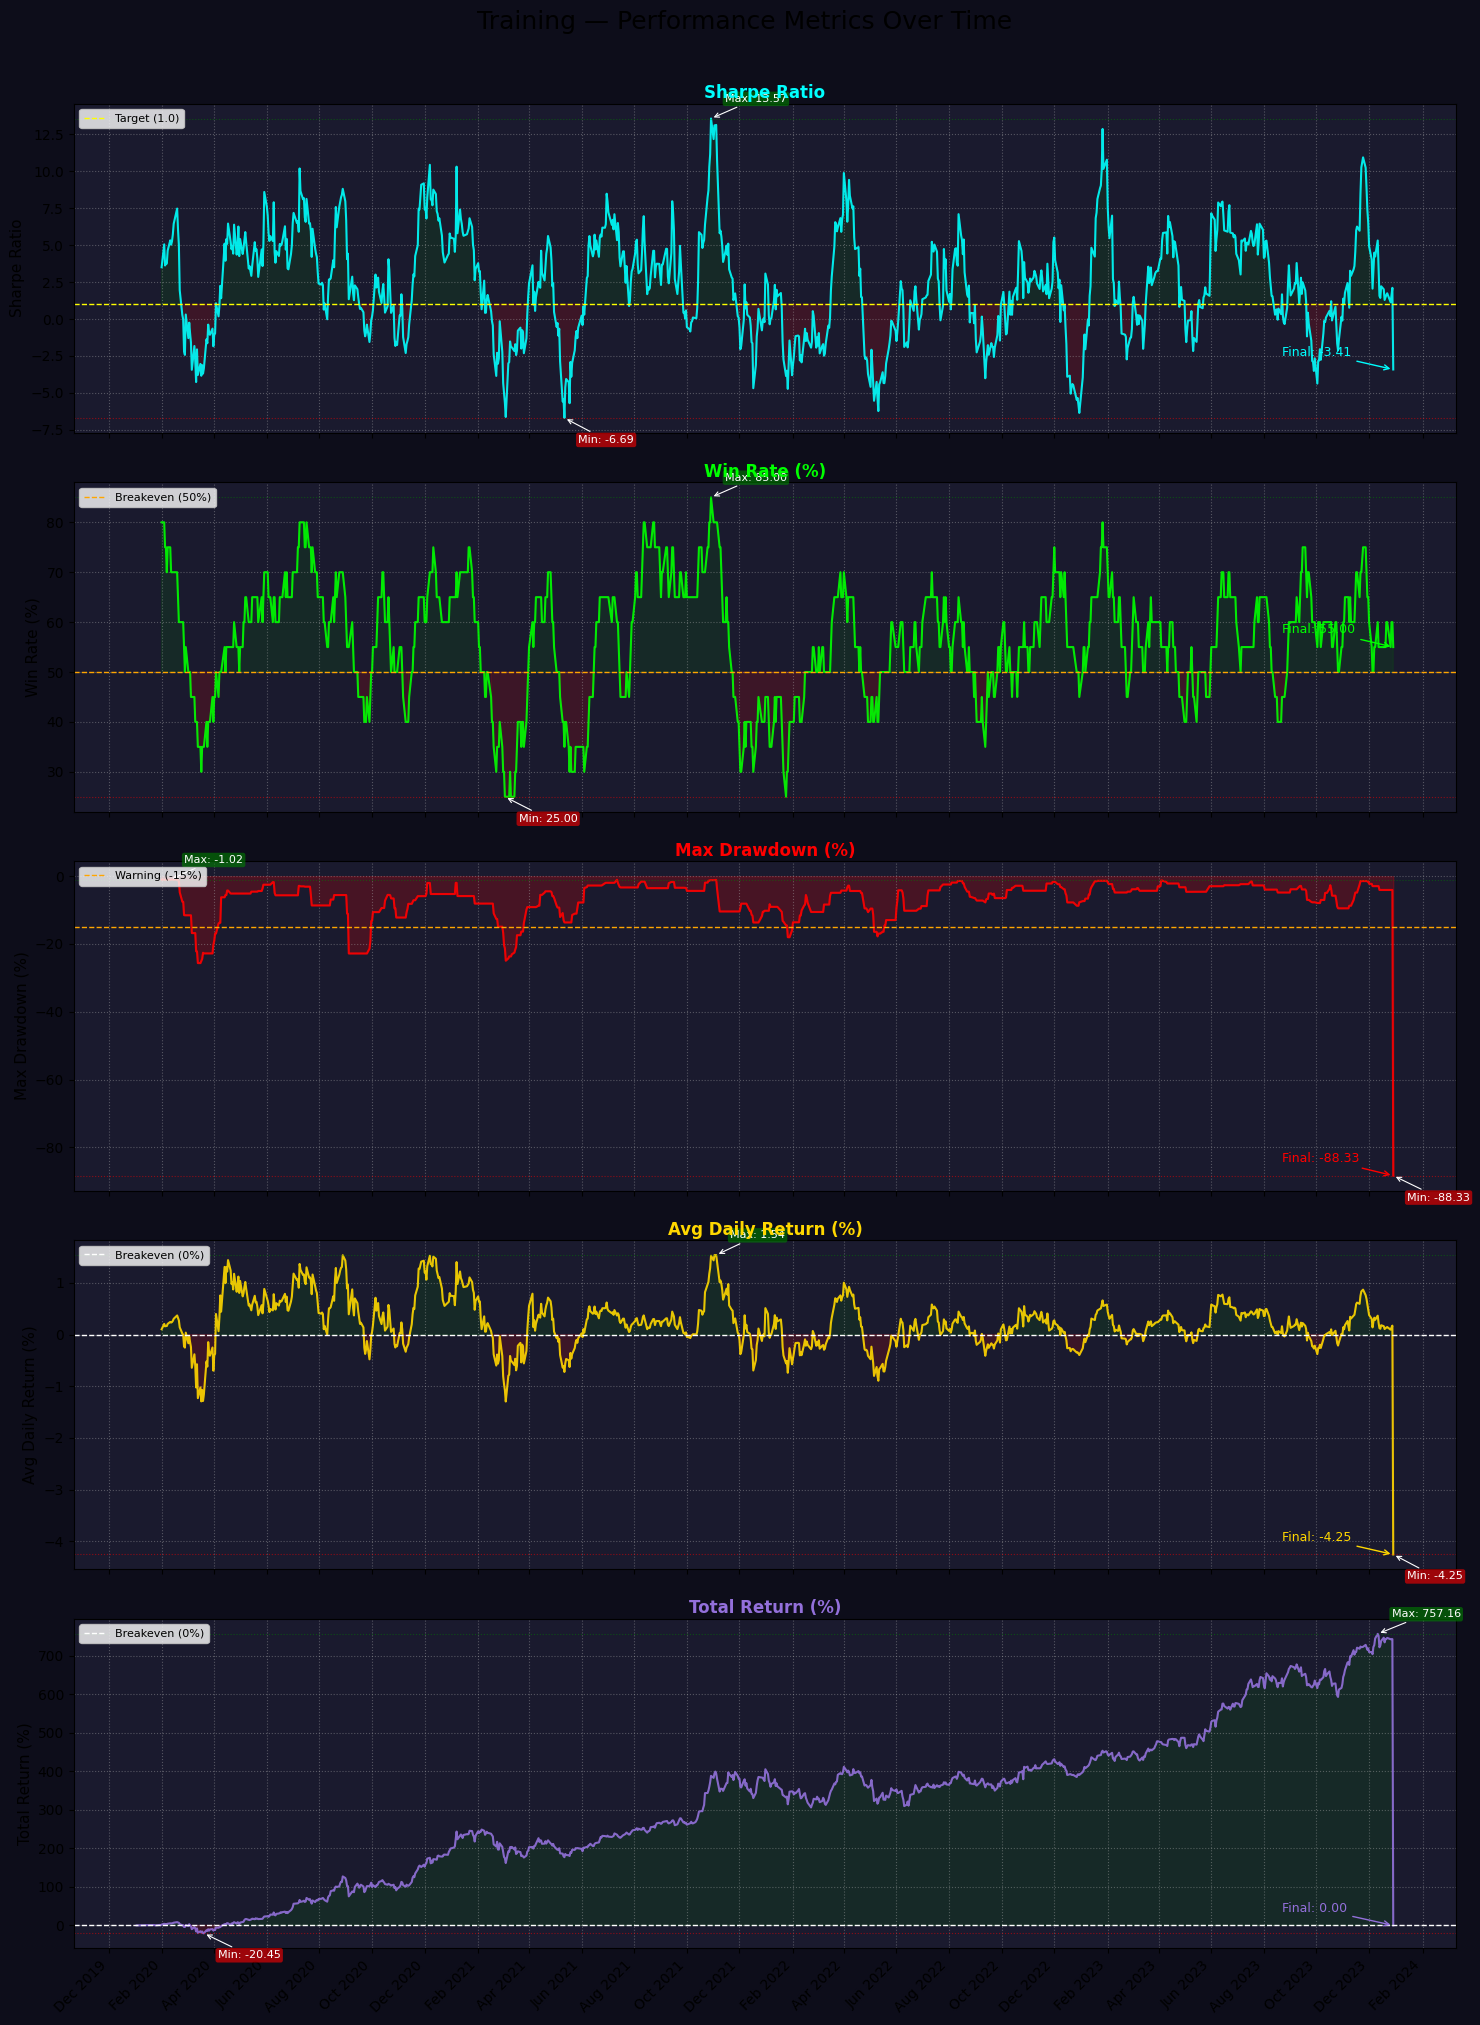


  TRAINING — METRIC SUMMARY
  Metric                         Avg      Max      Min    Final
  ---------------------------------------------------------
  Sharpe Ratio                  2.27    13.57    -6.69    -3.41
  Win Rate (%)                 56.34    85.00    25.00    55.00
  Max Drawdown (%)             -6.85    -1.02   -88.33   -88.33
  Avg Daily Return (%)          0.24     1.54    -4.25    -4.25
  Total Return (%)              0.00   757.16   -20.45     0.00


In [18]:
def plot_metrics(metrics_df: pd.DataFrame, title_prefix: str = 'Training'):
    fig, axes = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
    fig.suptitle(f'{title_prefix} — Performance Metrics Over Time',
                 fontsize=18, y=1.01)

    plot_config = [
        {'col': 'Sharpe Ratio',         'color': 'cyan',
         'ylabel': 'Sharpe Ratio',
         'hline': 1.0,  'hline_label': 'Target (1.0)',
         'hline_color': 'yellow'},
        {'col': 'Win Rate (%)',          'color': 'lime',
         'ylabel': 'Win Rate (%)',
         'hline': 50.0, 'hline_label': 'Breakeven (50%)',
         'hline_color': 'orange'},
        {'col': 'Max Drawdown (%)',      'color': 'red',
         'ylabel': 'Max Drawdown (%)',
         'hline': -15.0, 'hline_label': 'Warning (-15%)',
         'hline_color': 'orange'},
        {'col': 'Avg Daily Return (%)',  'color': 'gold',
         'ylabel': 'Avg Daily Return (%)',
         'hline': 0.0,  'hline_label': 'Breakeven (0%)',
         'hline_color': 'white'},
        {'col': 'Total Return (%)',      'color': 'mediumpurple',
         'ylabel': 'Total Return (%)',
         'hline': 0.0,  'hline_label': 'Breakeven (0%)',
         'hline_color': 'white'},
    ]

    for ax, cfg in zip(axes, plot_config):
        series = metrics_df[cfg['col']].dropna()

        ax.plot(series.index, series.values,
                color=cfg['color'], linewidth=1.5, alpha=0.9)
        ax.axhline(cfg['hline'], color=cfg['hline_color'],
                   linestyle='--', linewidth=1,
                   label=cfg['hline_label'])

        if cfg['col'] == 'Max Drawdown (%)':
            ax.fill_between(series.index, series.values, 0,
                            alpha=0.2, color='red')
        else:
            ax.fill_between(series.index, series.values, cfg['hline'],
                            where=series.values >= cfg['hline'],
                            alpha=0.15, color='green')
            ax.fill_between(series.index, series.values, cfg['hline'],
                            where=series.values < cfg['hline'],
                            alpha=0.15, color='red')

        ax.set_title(cfg['col'], fontsize=12, color=cfg['color'],
                     fontweight='bold', pad=4)
        ax.set_ylabel(cfg['ylabel'], fontsize=11)
        ax.grid(True, linestyle=':', alpha=0.4)
        ax.set_facecolor('#1a1a2e')

        if len(series) > 0:
            final_val = series.iloc[-1]
            max_val   = series.max()
            min_val   = series.min()
            max_date  = series.idxmax()
            min_date  = series.idxmin()

            # ── Final value annotation ────────────────────────
            ax.annotate(
                f'Final: {final_val:.2f}',
                xy=(series.index[-1], final_val),
                xytext=(-80, 10),
                textcoords='offset points',
                fontsize=9,
                color=cfg['color'],
                arrowprops=dict(arrowstyle='->',
                                color=cfg['color'], lw=1)
            )

            # ── Max value annotation ──────────────────────────
            ax.annotate(
                f'Max: {max_val:.2f}',
                xy=(max_date, max_val),
                xytext=(10, 12),
                textcoords='offset points',
                fontsize=8,
                color='white',
                bbox=dict(boxstyle='round,pad=0.2',
                          fc='green', alpha=0.6, ec='none'),
                arrowprops=dict(arrowstyle='->',
                                color='white', lw=0.8)
            )

            # ── Min value annotation ──────────────────────────
            ax.annotate(
                f'Min: {min_val:.2f}',
                xy=(min_date, min_val),
                xytext=(10, -18),
                textcoords='offset points',
                fontsize=8,
                color='white',
                bbox=dict(boxstyle='round,pad=0.2',
                          fc='red', alpha=0.6, ec='none'),
                arrowprops=dict(arrowstyle='->',
                                color='white', lw=0.8)
            )

            # ── Horizontal reference lines for max/min ────────
            ax.axhline(max_val, color='green', linestyle=':',
                       linewidth=0.8, alpha=0.5)
            ax.axhline(min_val, color='red', linestyle=':',
                       linewidth=0.8, alpha=0.5)

        ax.legend(loc='upper left', fontsize=8)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    plt.setp(axes[-1].get_xticklabels(), rotation=45, ha='right')
    fig.patch.set_facecolor('#0d0d1a')
    fig.tight_layout()
    plt.show()

    # ── Summary table with max/min/avg ────────────────────────
    print(f"\n{'='*60}")
    print(f"  {title_prefix.upper()} — METRIC SUMMARY")
    print(f"{'='*60}")
    print(f"  {'Metric':<25} {'Avg':>8} {'Max':>8} {'Min':>8} {'Final':>8}")
    print(f"  {'-'*57}")
    for col in metrics_df.columns:
        series    = metrics_df[col].dropna()
        if col == 'Total Return (%)':
            avg_val = series.iloc[-1]
        else:
            avg_val = series.mean()
        max_val   = series.max()
        min_val   = series.min()
        final_val = series.iloc[-1]
        print(f"  {col:<25} {avg_val:>8.2f} {max_val:>8.2f} "
              f"{min_val:>8.2f} {final_val:>8.2f}")
    print(f"{'='*60}")


# Plot training metrics
train_rolling = compute_rolling_metrics(df_train_account, window=20)
plot_metrics(train_rolling, title_prefix='Training')

Running prediction on test environment...
VecNormalize stats loaded ✅
Running prediction — 252 trading days...
Prediction complete — 252 steps
Account values collected: 252
Portfolio range: $979,535.95 — $1,385,998.96

  TEST PERFORMANCE METRICS
  Total Return (%)                 0.0
  Peak Return (%)                 38.6
  Peak Date                 2024-12-10
  Final Value ($)            1000000.0
  Peak Value ($)            1385998.96
  Sharpe Ratio                   0.162
  Max Drawdown (%)              -27.85
  Win Rate (%)                   55.78
  Avg Daily Return (%)          0.0183
  Volatility (%)                 28.44
  Calmar Ratio                     0.0


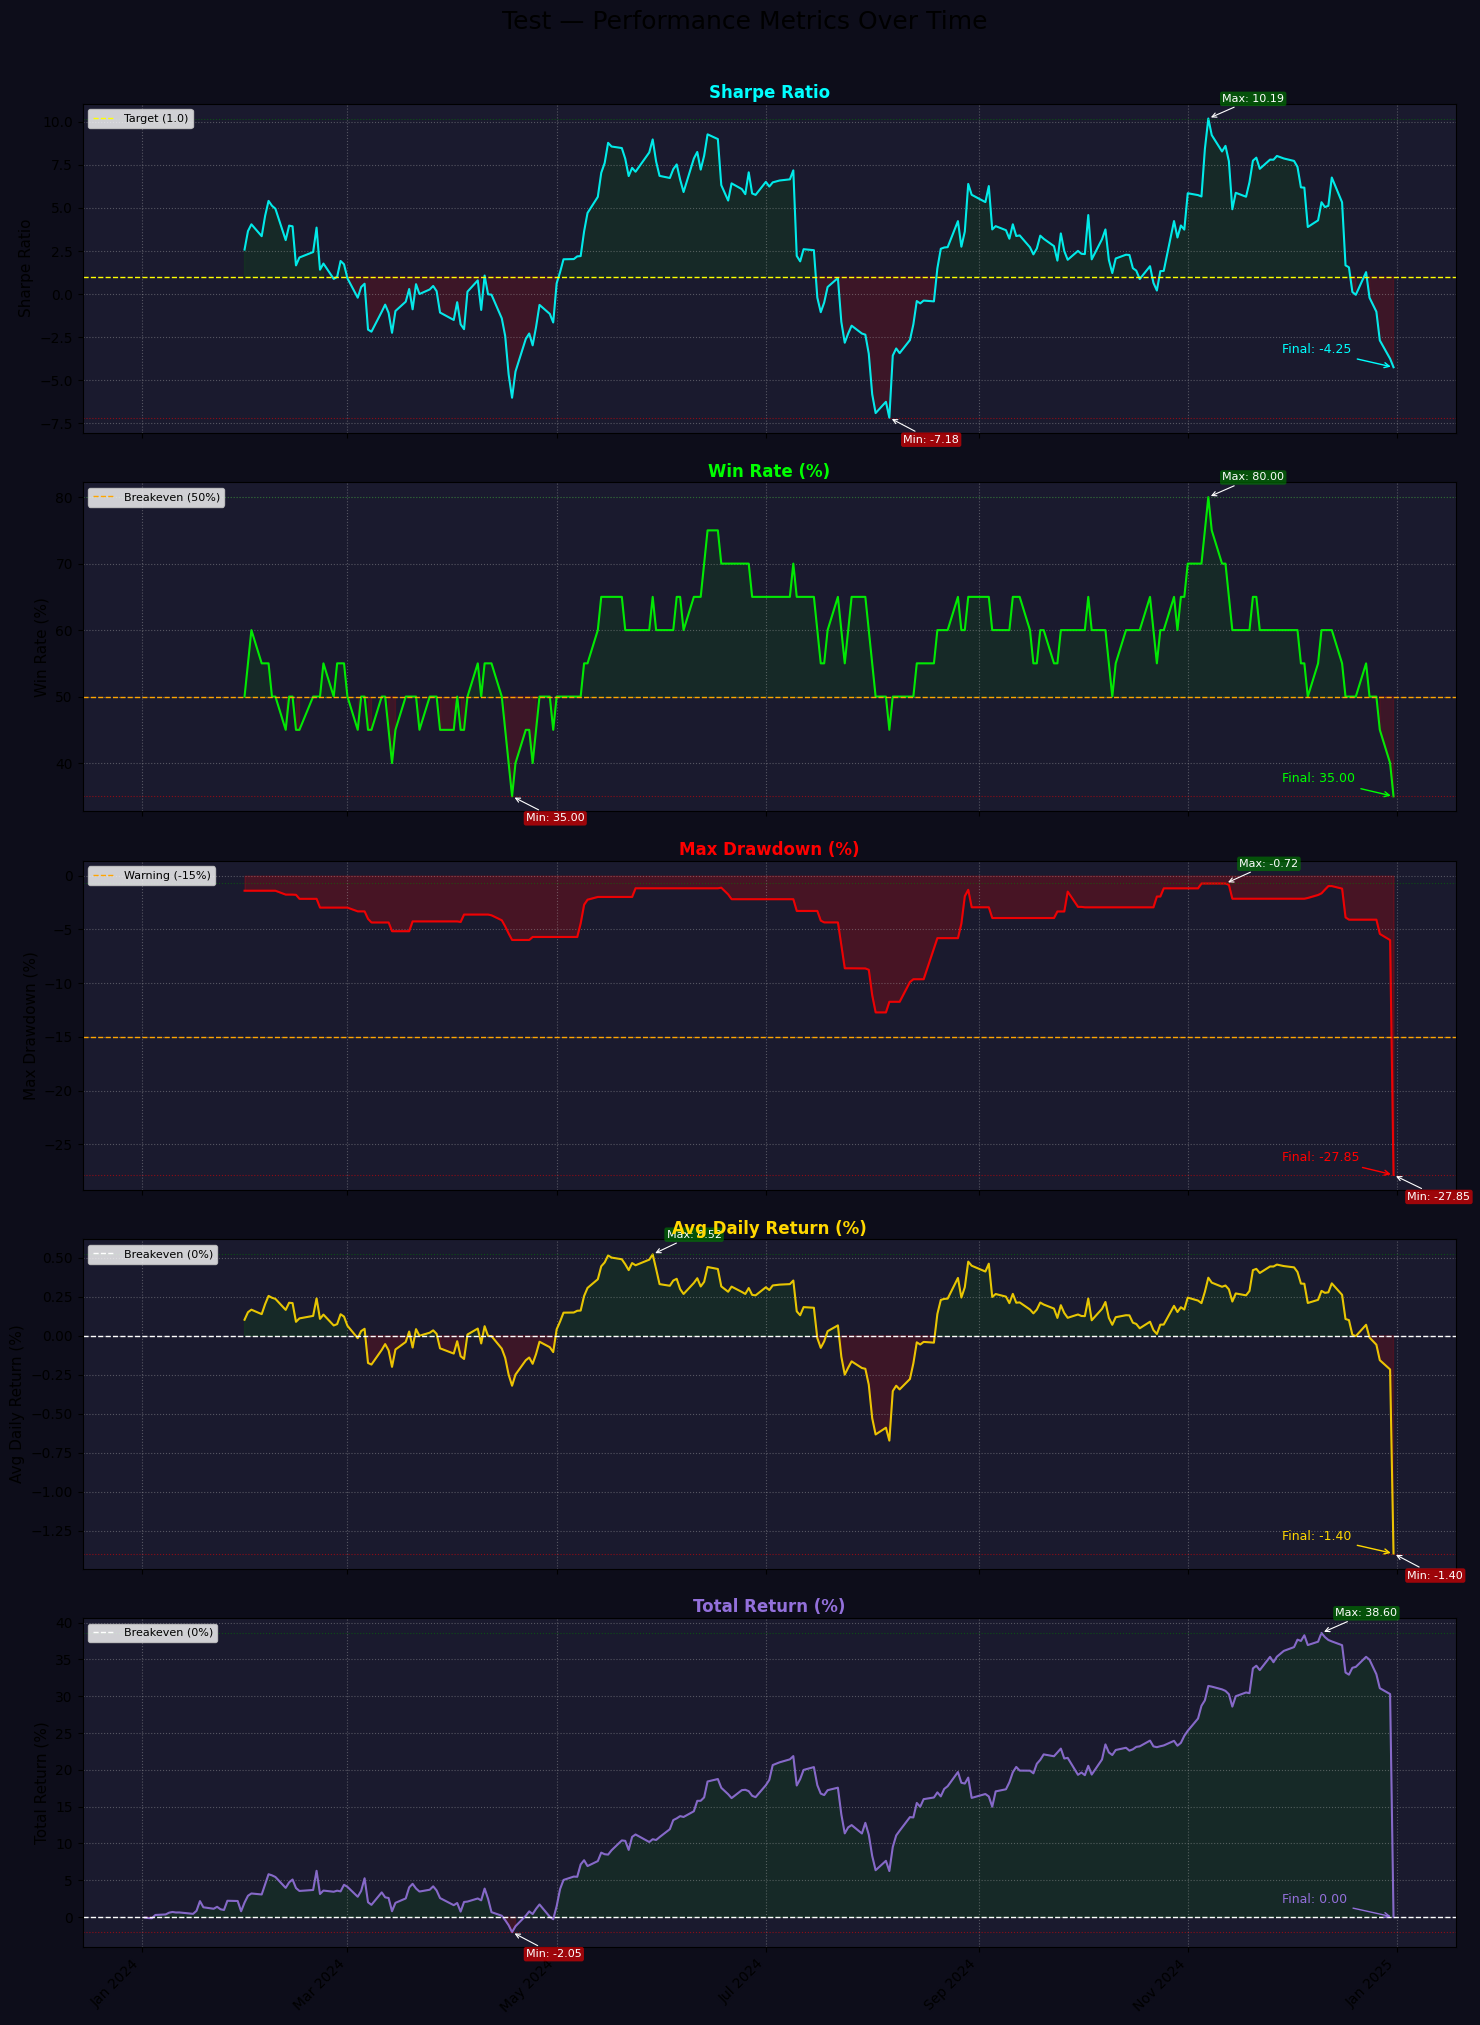


  TEST — METRIC SUMMARY
  Metric                         Avg      Max      Min    Final
  ---------------------------------------------------------
  Sharpe Ratio                  2.67    10.19    -7.18    -4.25
  Win Rate (%)                 57.07    80.00    35.00    35.00
  Max Drawdown (%)             -3.67    -0.72   -27.85   -27.85
  Avg Daily Return (%)          0.13     0.52    -1.40    -1.40
  Total Return (%)              0.00    38.60    -2.05     0.00


In [20]:
# ============================================================
# CELL 7 — Test Prediction & Plot
# ============================================================
print("Running prediction on test environment...")
df_account_value, df_actions = predict_with_sequence_env(
    trained_tfm, df_test, norm_path='vec_normalize.pkl'
)

test_metrics = compute_metrics(
    df_account_value['account_value'].tolist(),
    df_account_value['date'].values
)
print(f"\n{'='*45}")
print(f"  TEST PERFORMANCE METRICS")
print(f"{'='*45}")
for metric, value in test_metrics.items():
    if isinstance(value, str):
        print(f"  {metric:<25} {value:>10}")
    else:
        print(f"  {metric:<25} {value:>10}")
print(f"{'='*45}")

# Plot test rolling metrics with titles, max/min annotations
test_rolling = compute_rolling_metrics(df_account_value, window=20)
plot_metrics(test_rolling, title_prefix='Test')

# ── Plot cumulative shares held ───────────────────────────────
df_shares_held = df_actions.cumsum()
dates_all      = pd.to_datetime(df_account_value['date'].values)

min_len     = min(len(dates_all), len(df_shares_held))
dates_plot  = dates_all[:min_len]
shares_plot = df_shares_held.iloc[:min_len]


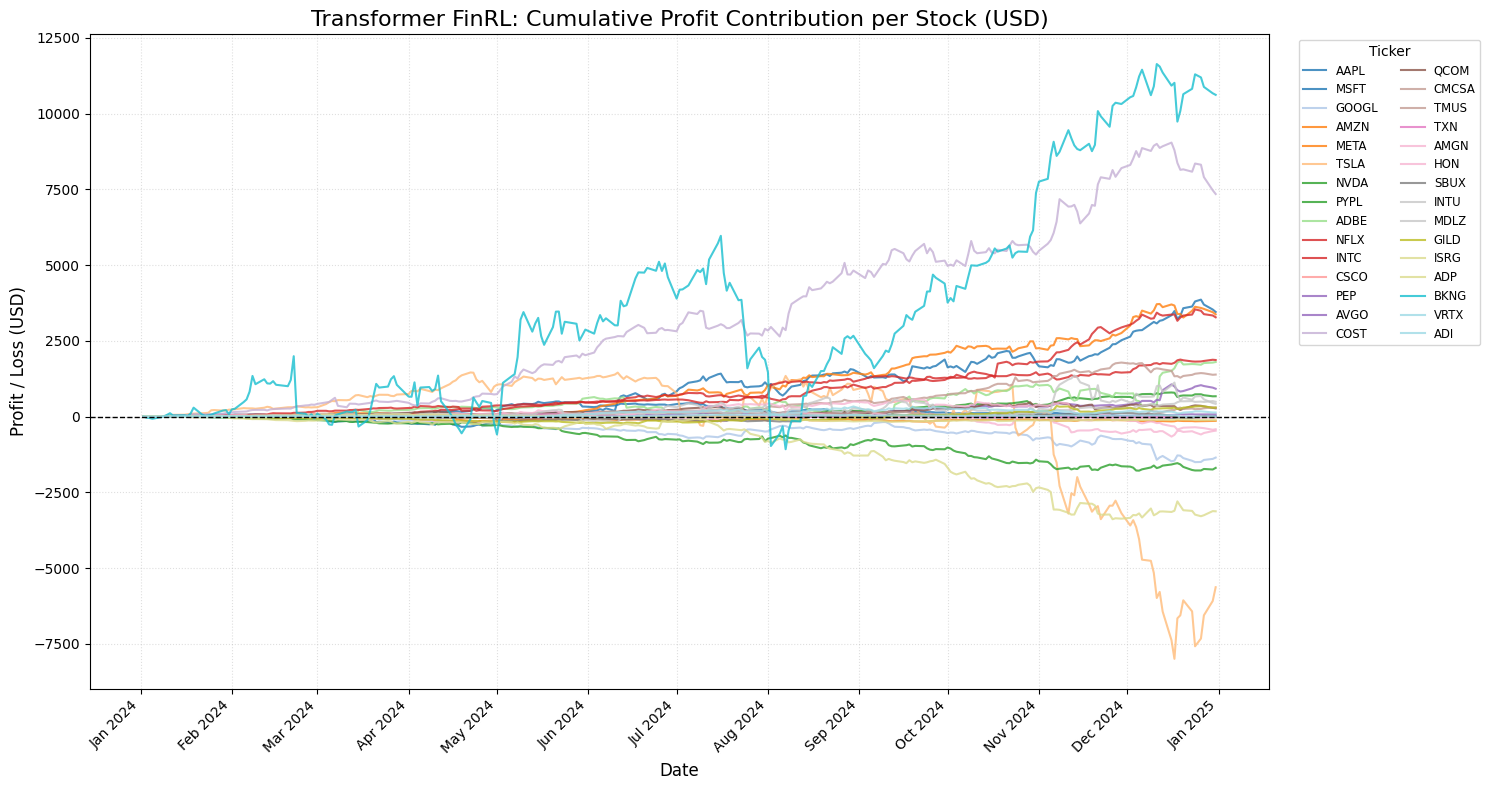

In [21]:
# ============================================================
# CELL 8 — Plot Profit Contribution per Stock
# ============================================================
df_prices_pivot = (
    df_test
    .sort_values(['date', 'tic'])
    .pivot(index='date', columns='tic', values='close')
)

df_shares_held        = df_actions.cumsum()
df_shares_held.index  = dates_all[:len(df_shares_held)]

price_dates           = pd.to_datetime(df_prices_pivot.index)
df_prices_pivot.index = price_dates
df_shares_aligned     = df_shares_held.reindex(price_dates).ffill().fillna(0)

profit_df = pd.DataFrame(index=price_dates)
for ticker in TICKERS:
    if ticker in df_prices_pivot.columns and \
       ticker in df_shares_aligned.columns:
        prices            = df_prices_pivot[ticker]
        initial_price     = prices.iloc[0]
        profit_df[ticker] = (prices - initial_price) * \
                             df_shares_aligned[ticker]

fig, ax = plt.subplots(figsize=(15, 8))
colormap = plt.get_cmap('tab20', len(TICKERS))

for i, ticker in enumerate(TICKERS):
    if ticker in profit_df.columns:
        ax.plot(profit_df.index, profit_df[ticker], label=ticker,
                color=colormap(i), linewidth=1.5, alpha=0.8)

ax.axhline(0, color='black', lw=1, linestyle='--')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Transformer FinRL: Cumulative Profit Contribution '
             'per Stock (USD)', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Profit / Loss (USD)', fontsize=12)
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left',
          ncol=2, fontsize='small', title='Ticker')
ax.grid(True, linestyle=':', alpha=0.4)
fig.tight_layout()
plt.show()

In [22]:
# ============================================================
# CELL 9 — Compute True P&L
# ============================================================
true_pnl_df = (df_prices_pivot * df_shares_aligned).fillna(0)
true_pnl_df = true_pnl_df.reset_index().rename(columns={'date': 'Date'})

In [23]:
# ============================================================
# CELL 10 — Interactive Plotly P&L Chart
# ============================================================
final_pnl   = true_pnl_df[TICKERS].iloc[-1]
top_5       = final_pnl.nlargest(5).index.tolist()
bottom_5    = final_pnl.nsmallest(5).index.tolist()
key_tickers = set(top_5 + bottom_5)

fig = go.Figure()
for ticker in TICKERS:
    if ticker not in true_pnl_df.columns:
        continue
    fig.add_trace(go.Scatter(
        x=true_pnl_df['Date'],
        y=true_pnl_df[ticker],
        name=ticker,
        mode='lines',
        visible=True if ticker in key_tickers else 'legendonly',
        hovertemplate=f"<b>{ticker}</b><br>PnL: %{{y:$.2f}}"
                      f"<br>Date: %{{x}}<extra></extra>"
    ))

fig.update_layout(
    title='Transformer FinRL: Individual Stock P&L',
    template='plotly_dark',
    hovermode='closest',
    hoverlabel=dict(bgcolor='black', font_size=13),
    xaxis_title='Date',
    yaxis_title='Profit / Loss (USD)',
    legend=dict(groupclick='toggleitem', traceorder='grouped')
)
fig.update_xaxes(rangeslider_visible=True)
fig.write_html("test_pnl.html")
print("Chart saved to test_pnl.html")

Chart saved to test_pnl.html


Future window: 2025-01-01 → 2026-02-24
Fetching Alpaca data: 2025-01-01 → 2026-02-24 for 30 tickers...
Fetched — shape: (8550, 8)
Date range: 2025-01-02 → 2026-02-23
Successfully added technical indicators
Fetching macro features for future period...
Macro features fetched — shape: (285, 5)
  Features: ['VIX', 'TNX', 'SPY', 'QQQ', 'XLK']
Fetching live sentiment via Polygon...
No cache found — fetching from Polygon...
Fetching Polygon sentiment for 30 tickers (2025-01-01 → 2026-02-24)...
  [30/30] ADI      
Done. Shape: (419, 30)
Non-zero entries: 12,424
✅ Cached to sentiment_future_polygon.pkl

Live sentiment coverage:
  Days with non-zero scores: 419 / 419
  Tickers with scores: 30 / 30
Sentiment merged — non-zero rows: 8441 / 8550
Macro features merged — 5 features
Future ready — 285 trading days
Running future prediction...
VecNormalize stats loaded ✅
Running prediction — 285 trading days...
Prediction complete — 285 steps
Account values collected: 285
Portfolio range: $899,326.27 —

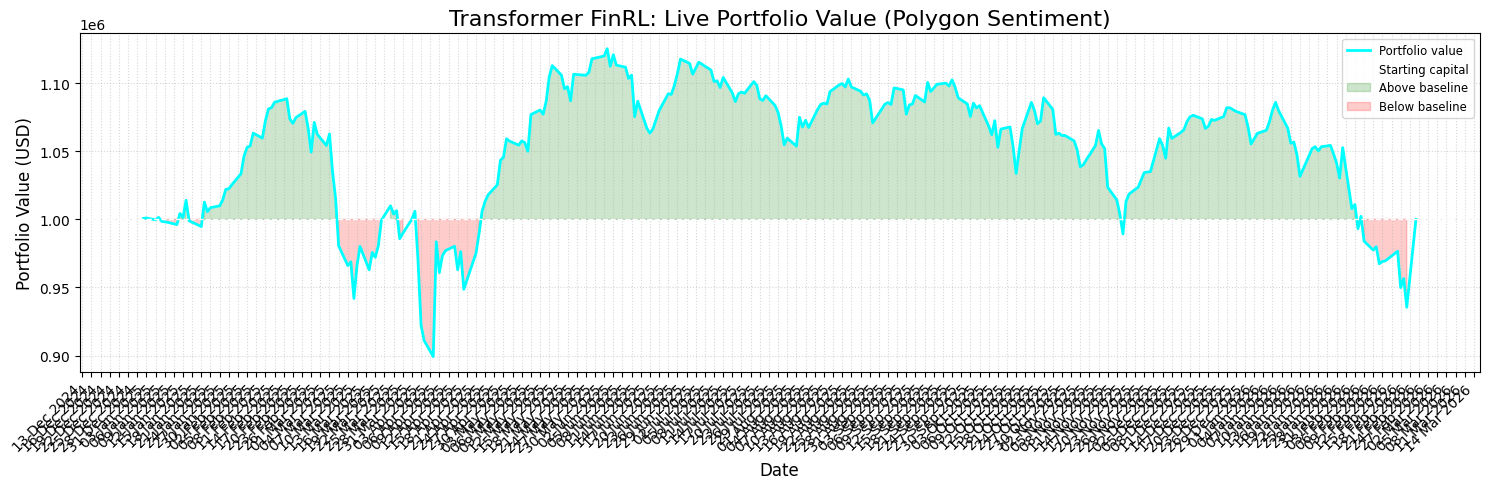

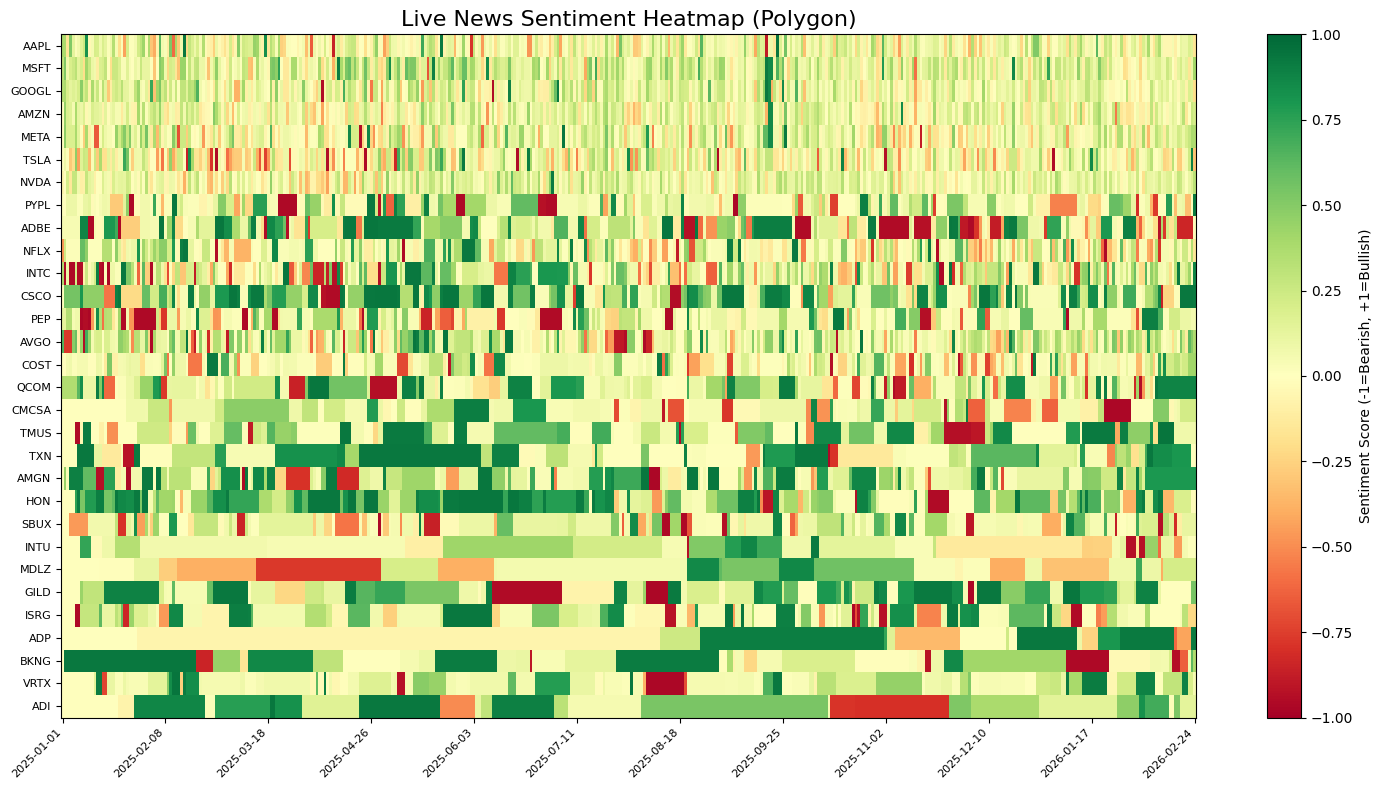

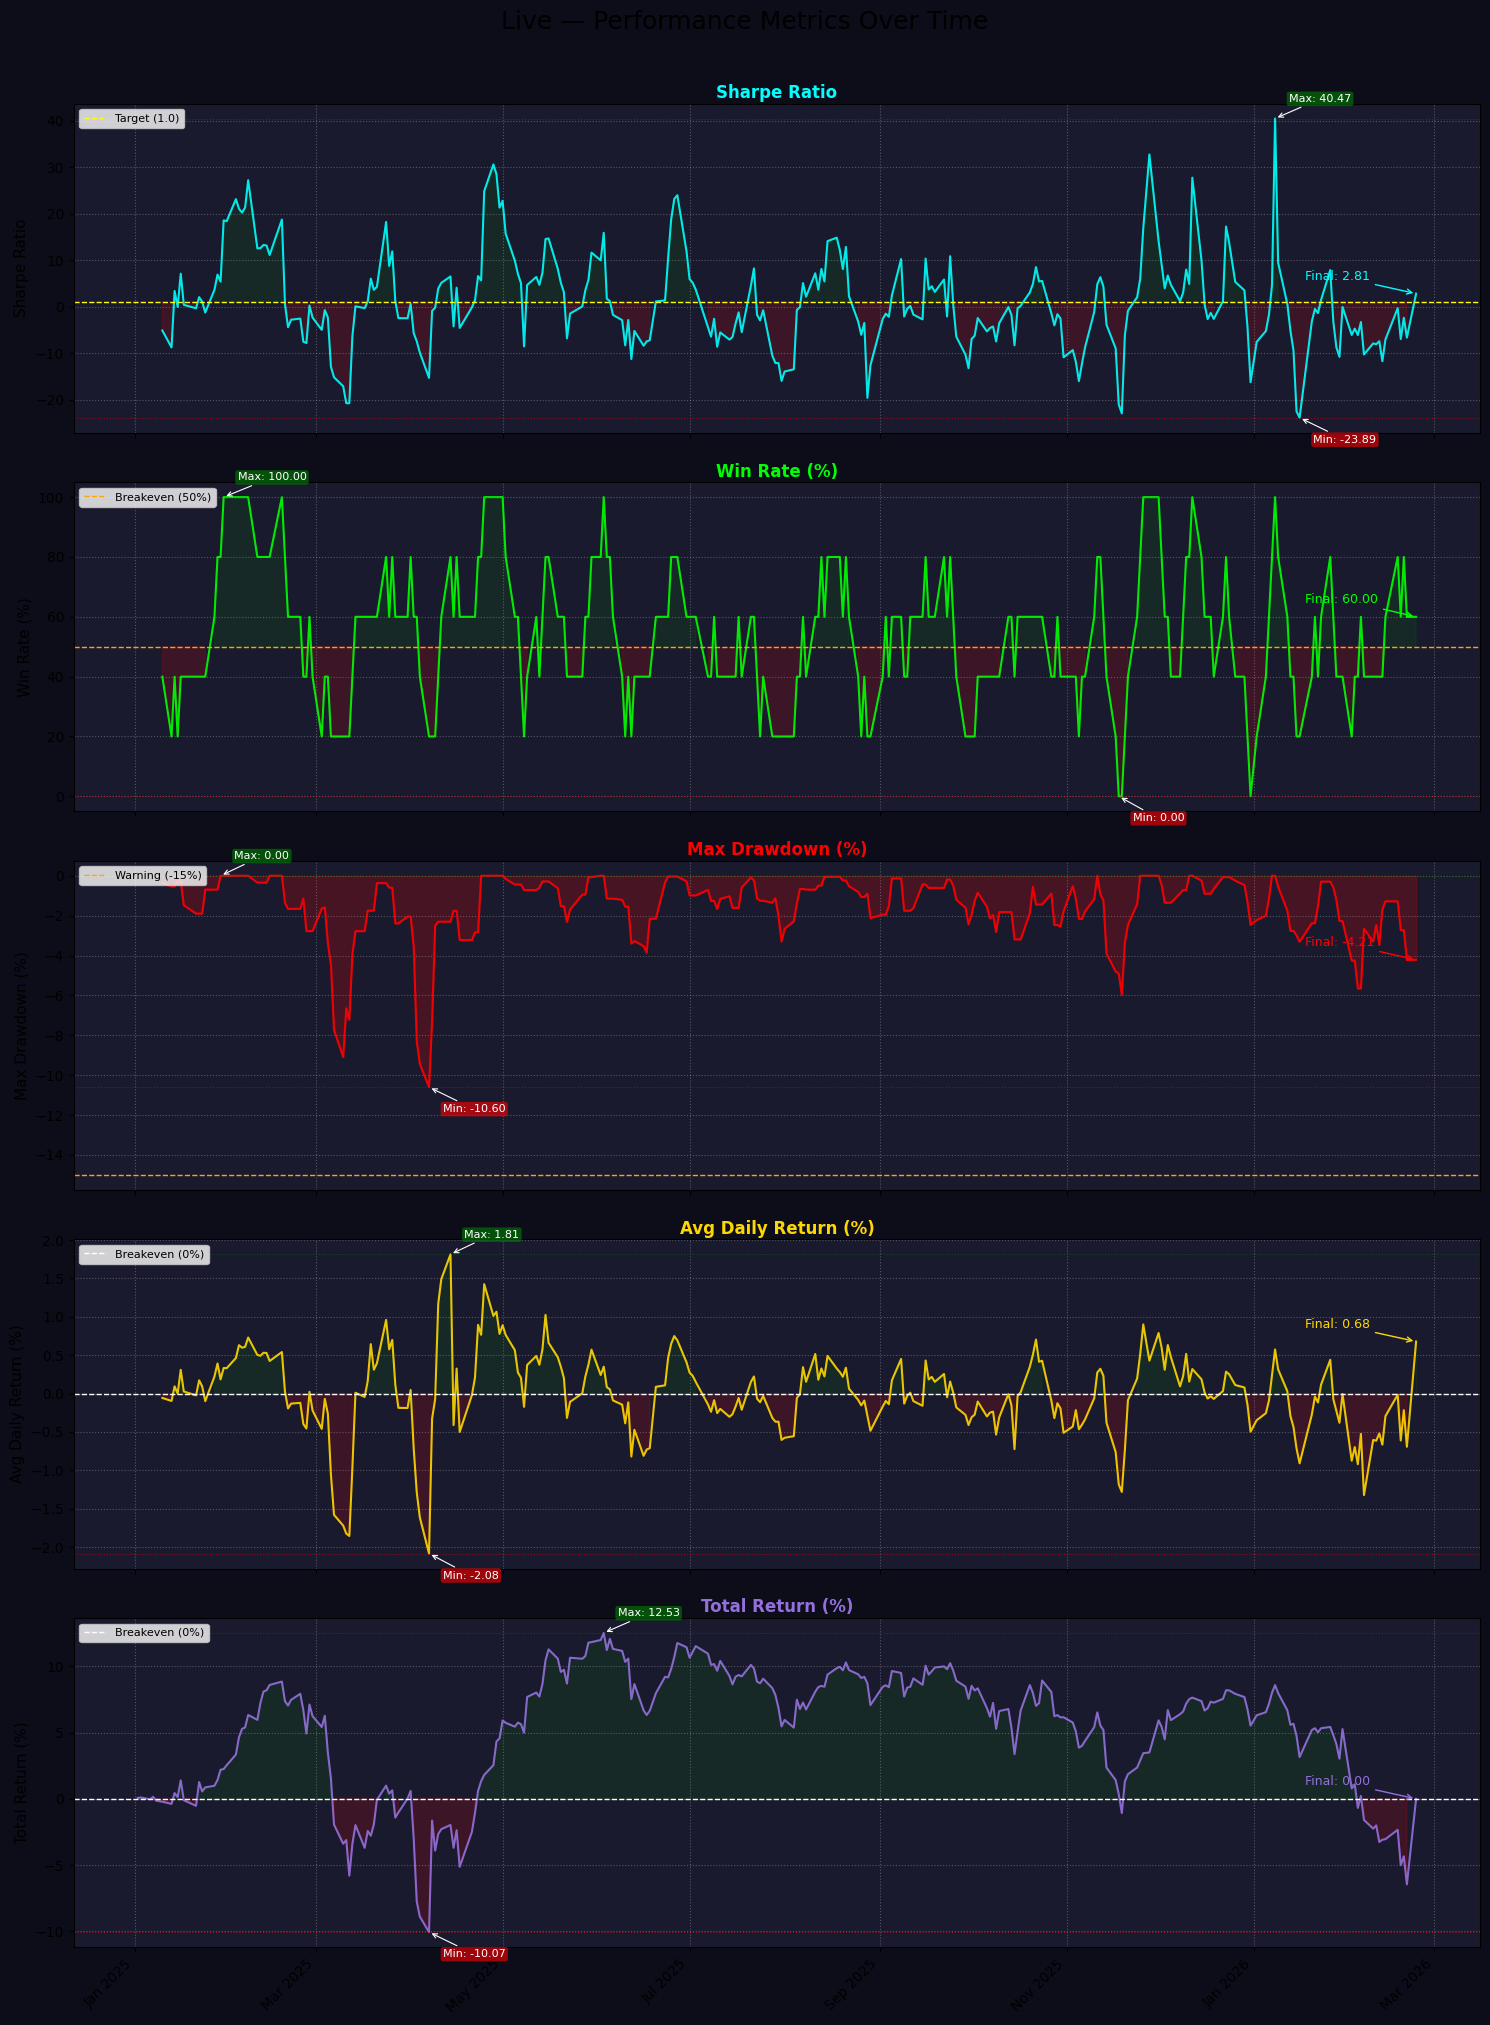


  LIVE — METRIC SUMMARY
  Metric                         Avg      Max      Min    Final
  ---------------------------------------------------------
  Sharpe Ratio                  1.04    40.47   -23.89     2.81
  Win Rate (%)                 54.14   100.00     0.00    60.00
  Max Drawdown (%)             -1.60     0.00   -10.60    -4.21
  Avg Daily Return (%)         -0.01     1.81    -2.08     0.68
  Total Return (%)              0.00    12.53   -10.07     0.00
Chart saved to live_pnl_polygon.html
Model returned to mps ✅


In [24]:
# ============================================================
# CELL 11 — Future Prediction with Live Polygon Data
# ============================================================
TODAY        = date.today()
FUTURE_START = '2025-01-01'
FUTURE_END   = TODAY.strftime('%Y-%m-%d')

print(f"Future window: {FUTURE_START} → {FUTURE_END}")

# Fetch price data via Alpaca
df_raw_future = fetch_alpaca_data(TICKERS, FUTURE_START, FUTURE_END)
df_future_raw = fe.preprocess_data(df_raw_future)

# Fetch macro features for future period
print("Fetching macro features for future period...")
df_macro_future = fetch_macro_features(FUTURE_START, FUTURE_END)

# Fetch live sentiment via Polygon — no date limit restriction
print("Fetching live sentiment via Polygon...")
df_sent_future = build_sentiment_df_cached(
    TICKERS,
    FUTURE_START,
    FUTURE_END,
    cache_file='sentiment_future_polygon.pkl'
)

print(f"\nLive sentiment coverage:")
print(f"  Days with non-zero scores: "
      f"{(df_sent_future != 0).any(axis=1).sum()} / {len(df_sent_future)}")
print(f"  Tickers with scores: "
      f"{(df_sent_future != 0).any(axis=0).sum()} / {len(TICKERS)}")

df_future = prepare_df(df_future_raw, df_sent_future, df_macro_future)
print(f"Future ready — {df_future['date'].nunique()} trading days")

print("Running future prediction...")
df_future_account, df_future_actions = predict_with_sequence_env(
    trained_tfm, df_future, norm_path='vec_normalize.pkl'
)

# Live metrics
future_metrics = compute_metrics(
    df_future_account['account_value'].tolist(),
    df_future_account['date'].values
)
print(f"\n{'='*45}")
print(f"  LIVE PERFORMANCE METRICS")
print(f"{'='*45}")
for metric, value in future_metrics.items():
    print(f"  {metric:<25} {value:>10}")
print(f"{'='*45}")

# ── Plot portfolio value ──────────────────────────────────────
future_dates = pd.to_datetime(df_future_account['date'].values)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(future_dates, df_future_account['account_value'],
        color='cyan', linewidth=2, label='Portfolio value')
ax.axhline(1_000_000, color='white', linestyle='--',
           linewidth=1, label='Starting capital')
ax.fill_between(future_dates, 1_000_000,
                df_future_account['account_value'],
                where=df_future_account['account_value'] >= 1_000_000,
                alpha=0.2, color='green', label='Above baseline')
ax.fill_between(future_dates, 1_000_000,
                df_future_account['account_value'],
                where=df_future_account['account_value'] < 1_000_000,
                alpha=0.2, color='red', label='Below baseline')

ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Transformer FinRL: Live Portfolio Value (Polygon Sentiment)',
             fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Value (USD)', fontsize=12)
ax.legend(fontsize='small')
ax.grid(True, linestyle=':', alpha=0.5)
fig.tight_layout()
plt.show()

# ── Sentiment heatmap ─────────────────────────────────────────
fig, ax = plt.subplots(figsize=(15, 8))
sent_plot = df_sent_future[TICKERS].T
im        = ax.imshow(sent_plot.values, aspect='auto', cmap='RdYlGn',
                      vmin=-1, vmax=1, interpolation='nearest')
ax.set_yticks(range(len(TICKERS)))
ax.set_yticklabels(TICKERS, fontsize=8)
n_cols   = sent_plot.shape[1]
tick_idx = np.linspace(0, n_cols - 1, min(12, n_cols)).astype(int)
ax.set_xticks(tick_idx)
ax.set_xticklabels(
    [sent_plot.columns[i] for i in tick_idx],
    rotation=45, ha='right', fontsize=8
)
plt.colorbar(im, ax=ax, label='Sentiment Score (-1=Bearish, +1=Bullish)')
ax.set_title('Live News Sentiment Heatmap (Polygon)', fontsize=16)
fig.tight_layout()
plt.show()

# ── Live rolling metrics ──────────────────────────────────────
future_rolling = compute_rolling_metrics(df_future_account, window=5)
plot_metrics(future_rolling, title_prefix='Live')

# ── Interactive Plotly P&L ────────────────────────────────────
df_future_prices = (
    df_future
    .sort_values(['date', 'tic'])
    .pivot(index='date', columns='tic', values='close')
)
future_price_dates     = pd.to_datetime(df_future_prices.index)
df_future_prices.index = future_price_dates
future_shares          = df_future_actions.cumsum()
future_shares_aligned  = future_shares.reindex(
    future_price_dates).ffill().fillna(0)

future_pnl_df = pd.DataFrame(index=future_price_dates)
for ticker in TICKERS:
    if ticker in df_future_prices.columns and \
       ticker in future_shares_aligned.columns:
        prices               = df_future_prices[ticker]
        initial_price        = prices.iloc[0]
        future_pnl_df[ticker] = (prices - initial_price) * \
                                  future_shares_aligned[ticker]

future_pnl_df    = future_pnl_df.reset_index().rename(
    columns={'date': 'Date'})
final_future_pnl = future_pnl_df[TICKERS].iloc[-1]
top_5            = final_future_pnl.nlargest(5).index.tolist()
bottom_5         = final_future_pnl.nsmallest(5).index.tolist()
key_tickers      = set(top_5 + bottom_5)

fig = go.Figure()
for ticker in TICKERS:
    if ticker not in future_pnl_df.columns:
        continue
    fig.add_trace(go.Scatter(
        x=future_pnl_df['Date'],
        y=future_pnl_df[ticker],
        name=ticker,
        mode='lines',
        visible=True if ticker in key_tickers else 'legendonly',
        hovertemplate=f"<b>{ticker}</b><br>PnL: %{{y:$.2f}}"
                      f"<br>Date: %{{x}}<extra></extra>"
    ))
fig.update_layout(
    title='Transformer FinRL: Live Stock P&L (Polygon Sentiment)',
    template='plotly_dark',
    hovermode='closest',
    hoverlabel=dict(bgcolor='black', font_size=13),
    xaxis_title='Date',
    yaxis_title='Profit / Loss (USD)',
    legend=dict(groupclick='toggleitem', traceorder='grouped')
)
fig.update_xaxes(rangeslider_visible=True)
fig.write_html("live_pnl_polygon.html")
print("Chart saved to live_pnl_polygon.html")

# Move model back to DEVICE after prediction
trained_tfm.policy.to(DEVICE)
gc.collect()
if th.backends.mps.is_available():
    th.mps.empty_cache()
print(f"Model returned to {DEVICE} ✅")

In [25]:
df_train.to_csv('FinRLTransformer_POLYGON_train.csv')
df_test.to_csv('FinRLTransformer_POLYGON_validation.csv')